PID4SMOG Tutorial
=========

### Welcome to the tutorial on the PID4SMOG package 

Documentation on the project motivation and a full proof-of-concept description can be found [LINK_TO_PAPER](); any comment or suggestion can be sent to <a href="mailto:mariani@fi.infn.it"> Saverio Mariani </a>

**TL;DR** The PID4SMOG library has been developed as a novel approach to particle identification (PID) studies for LHCb data collected in its fixed-target configuration, where the calibration data statistics, on which the PID classifier building relies, is scarce. As a general method, PID4SMOG employs machine learning techniques to describe the marginal pdf of a bidimensional classifier with a Gaussian Mixture Model (= composition of multinormal distributions) whose parameters are predicted by Multi Layer Perceptron neural networks trained on calibration data as a function of the relevant experimental features. The classifier dependences on the considered set of features are learned on a high-statistics training sample and then applied to a lower-statistic one to predict its classifier distributions. 

In the following, a minimal working example throughout the 
* preprocessing
* training
* overtraining and
* validation 

phases is described in all details. 

A local installation of Jupyter is required to interctively run the tutorial. If you've never use it before, you can maybe do [this training](https://mybinder.org/v2/gh/ipython/ipython-in-depth/master?filepath=binder/Index.ipynb) or take a quick look at [the documentation](https://jupyter-notebook.readthedocs.io/en/stable/notebook.html).

### Prerequisites

In [1]:
import os, sys
import root_pandas as rpd
import ROOT

from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False #Just removing some warnings

Welcome to JupyROOT 6.17/01


#### Graphics

By default in the project and in this tutorial, the graphics is managed by the [root_report](https://github.com/landerlini/root_report) library, a simple python package to create HTML report out of CERN ROOT scripts. A steering class, named HistReport, is implemented in Graphic_Helper.py, providing useful helper methods to build ROOT graphic objects, draw them and manage their graphic details like labels, titles, colors and so on. 
The HTML page steering object is called with the only required arguments of a name and a save directory. Optionally, also a dictionary with the axes titles in a TLatex format and a TLatex message common to all drawn object (e.g. the considered sample) can be added. 

In [2]:
from Graphic_Helper import HistReport

report = HistReport("report_tutorial", path = "./report_dir", var_axes = {"pi_ETA" : "#pi #eta"} ) #HTML page name, save report directory
report.outputTitle("PID4SMOG tutorial")

img_path = report.get_path() + "/img/"

#### Dataset description

The considered dataset is a random generation of $\Lambda_c \to p K \pi$ decays mimicking *pp* data collected by the LHCb experiment and offering a final state presenting all the three most commonly produced hadrons. This dataset **is NOT** an LHCb official simulation.

Let's start by only considering signal events by requiring the true identities of all the final state particles to match the required ones. As a second step, both signal and backgroud events can be considered and distinguished by the signal weights w_sig obtained with the application of the *sPlot* technique applied to the $\Lambda_c$ invariant mass distribution.  

In [3]:
dataset = rpd.read_root("data/TestNtuple_Lc2pKpi_sW.root", 
                        where   = "pi_TRUE_ID == pi_ID & K_TRUE_ID == K_ID & p_TRUE_ID == p_ID", 
                        columns = ["pi_DLL{ppi,Kpi}", "pi_{P,ETA,TRACK_CHI2NDOF}", "nTracks"]# + ["w_sig"]
                        )
dataset.describe()

pi_DLLKpi  pi_TRACK_CHI2NDOF      pi_DLLppi         pi_ETA  \
count  264007.000000      264007.000000  264007.000000  264007.000000   
mean      -31.456964           1.106605     -30.570221       3.133774   
std        22.928627           0.342235      21.407663       0.633985   
min      -148.612274           0.256143    -146.812378       1.727296   
25%       -45.686296           0.879581     -43.579660       2.631075   
50%       -29.123178           1.058407     -29.096363       3.086859   
75%       -13.914078           1.273209     -15.660050       3.594272   
max        35.288116           2.659001      59.782410       4.889464   

             nTracks          pi_P  
count  264007.000000  2.640070e+05  
mean      211.132095  2.716566e+04  
std       114.168144  2.757596e+04  
min        10.000000  3.057639e+03  
25%       138.000000  1.152641e+04  
50%       186.000000  1.906332e+04  
75%       250.000000  3.300755e+04  
max       994.000000  1.263240e+06

The columns accessed in the dataset are:
- pi_DLL_{pK,Kpi,ppi} : difference between the log likelihood functions for the {proton-Kaon, Kaon-pion, proton-pion} hypotheses for the pion
- pi_P              : pion momentum 
- pi_ETA            : pion pseudorapidity
- pi_TRACK_CHI2NDOF : pion track $\chi^2/ndf$ of the track fit 
- nTracks           : overall number of tracks in the event

Variables can be divided into:

1 **Target variables**,  the ones that need to be predicted by the model

2 **Feature variables**, that are the expected relevant quantities affecting the target values

In the example described here, the target is chosen as DLL_Kpi and DLL_ppi, which are expected to mostly depend on the particle kinematics, the overall detector occupancy and the track reconstruction quality. 

Additionally, the dataset can be **weighted** to distinguish the signal from the background (e.g. with the sPlot technique) or to enhance the statistic significance of a phase space region.  

In [4]:
target   = ["pi_DLLppi", "pi_DLLKpi"]#What variables do you want to predict?
features = ["pi_P", "pi_ETA", "pi_TRACK_CHI2NDOF", "nTracks"] #Which dependencies to explore?
weight   =  None #Are events somehow weighted (e.g. via sPlot)?
#weight   = "w_sig"

#### Training parameters
Secondly, all the parameters of the Gaussian Mixture Model to be initialized during the training need to be defined:
- **nGaussians** : number of multinormal distributions to be combined to reproduce the target
- **nNodes**     : number of nodes in each neural network hidden layer
- **nLayers**    : number of hidden layers in the neural network 
- **nEpochs**    : number of iterations for the coarse and fine trainings
- **batch size** : number of events to be considered for each iteration
- **max_lr**     : starting learning rate

flags can activate the drawing of all the histograms and the saving of the model at the end of the training

In [5]:
parameters = {  "nGaussians"  :  8                ,  #(int)   number of Gaussian distributions to use in the model     
                "nNodes"      :  16               ,  #(int)   number of NN Nodes to study dependence on features       
                "nLayers"     :  2                ,  #(int)   number of hidden layers in the NN                        
                "nEpochs"     : [100, 1500]       ,  #(list)  number of epochs for the coarse and fine training        
                "batch_size"  : 15000             ,  #(int)   number of entries considered for each iteration          
                "max_lr"      : 5e-4              }  #(float) starting learning rate                                   

flags = { '__All_Hist__' : True, '__SAVE__' : True } 

#### Preprocessing phase

To speed-up the training phase, two preprocessing algorithms are applied to training and feature variables.
* Target variable distributions, which the Gaussian Mixture Model aims to reproduce, cannot be distorted and are indeed only scaled with a linear transformation (**MinMaxScaler** in scikit-learn) to the [0,1] range
* Feature variables are not reproduced by the model and their pdfs are mapped to normal distributions by the  **QuantileTransformer** algorithm in scikit-learn). This also equalizes the scale of all the feature contributions, which spans several orders of magnitude 

In [6]:
from pid4smog import Training
model = Training( dataset = dataset, variables = {"target" : target, "features" :features, "weight" : weight},
                  parameters = parameters, flags = flags)
skimd_df = model.preprocess( report ) #go with the variable preprocessing


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Target:    ['pi_DLLppi', 'pi_DLLKpi']
Features:  ['pi_P', 'pi_ETA', 'pi_TRACK_CHI2NDOF', 'nTracks']
Weights:   None


Below, two examples of the MinMaxScaler (top) and QuantileTransformer (bottom) application 

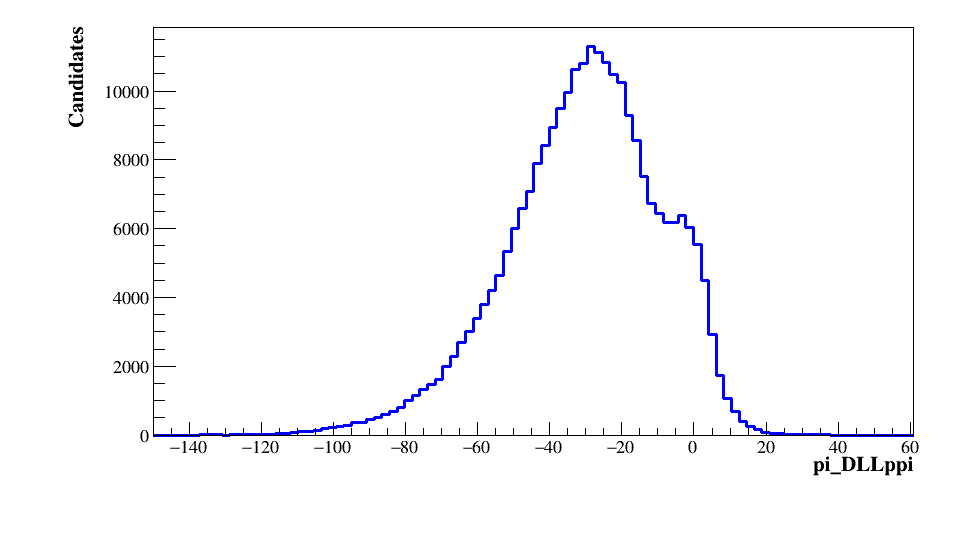

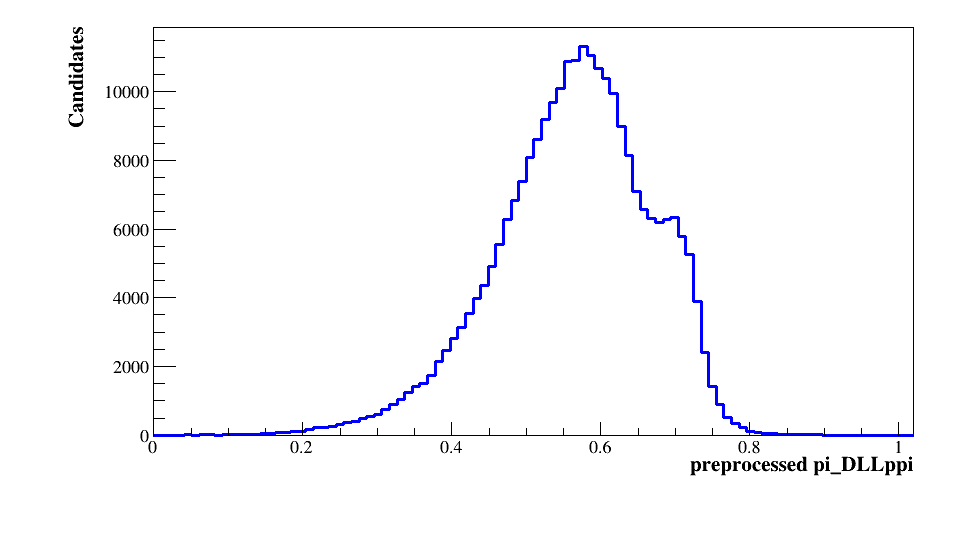

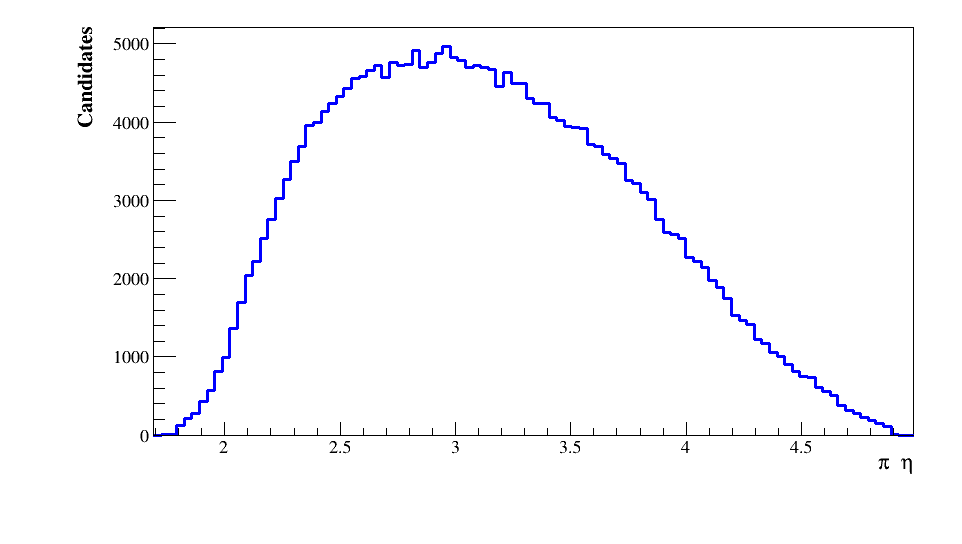

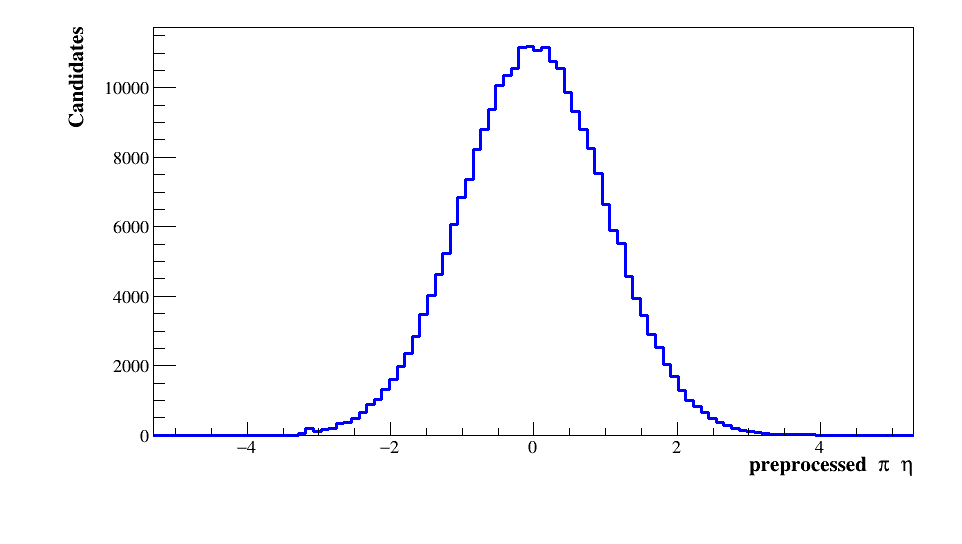

In [7]:
vars_to_draw = ["pi_DLLppi", "pi_ETA"] 
for ivar in vars_to_draw:
    figs = [os.path.join( img_path, i) for i in os.listdir(img_path) if all(k in i for k in [report.get_filename(), ivar, ".root"]) if any(l in i for l in ["DataDistr", "Preprocessed"])] 
    figs.sort(key=lambda x: os.path.getmtime(x))

    for ifig in figs:
        f = ROOT.TFile.Open( ifig )
        ic = f.Get(report.get_filename())
        ic.SetName("C_" + ifig)
        ic.Draw()
        
ROOT.gPad.SetName( report.get_filename() )

#### Training phase

The Gaussian Mixture Model, a composition of nGaussian multinormals with diagonal correlation matrix is defined with a starting random initialization:
* Gaussian means 
    $\def\xPID  {x} \mu \in \left[\langle \xPID_{1,2} \rangle - \frac{1}{2}\sqrt{\langle \xPID_{1,2}^2\rangle - \langle \xPID_{1,2}\rangle^2}, \,\, \langle \xPID_{1,2} \rangle + \frac{1}{2}\sqrt{\langle \xPID_{1,2}^2\rangle - \langle \xPID_{1,2}\rangle^2 } \right]$
* Gaussian width 
$\def\xPID  {x} \sigma \in \left[\frac{1}{10}\sqrt{\langle \xPID_{1,2}^2\rangle - \langle \xPID_{1,2}\rangle^2} , \sqrt{\langle \xPID_{1,2}^2\rangle - \langle \xPID_{1,2}\rangle^2 }\right]$
* Gaussian weights in the composition $\alpha \in [0., 1.]$ 

To take into account the correlation between the target variables, which is linear at a good extent, a rotation by an angle $\alpha$, randomly initialized in $[0, 2\pi]$, is applied to data. 

To the random initialization, for each parameter the output of a Neural Networks feeded with the feature variables is added.

All parameters are iteratively adjusted to maximize the likelihood function for the Gaussian Mixture Model application to the training target distribution, i.e. to minimize the loss, which is defined as the opposite of the likelihood logarithm. 

The training is performed in two steps: firstly, the Neural Network outputs are disabled, in order to find a coarse initilization of the parameters; secondly, the target dependences on the considered set of features is studied -> **Time for a coffee?**. 

At the end of the training (it can be stopped at any time running on a terminal) the preprocessing algorithms, the variables and the trained model are saved in MODELS/PID_saved_model_<report_name>_<date_and_time>.

The evolution of the loss function and the current learning rate are shown in the description of the progress bar.

In [8]:
model.train( report, skimd_df )

********************************************************************************
****************************** Starting TRAINING******************************
********************************************************************************


-6.5895, 0.000000: 100%|██████████| 1500/1500 [01:28<00:00, 16.45it/s]


INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: MODELS/PID_saved_model_report_tutorial_2021-01-03-11-50/saved_model.pb


2021-01-03 11:48:42.458534: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2600215000 Hz
2021-01-03 11:48:42.463413: I tensorflow/compiler/xla/service/service.cc:150] XLA service 0x559f3d2aa700 executing computations on platform Host. Devices:
2021-01-03 11:48:42.463494: I tensorflow/compiler/xla/service/service.cc:158]   StreamExecutor device (0): <undefined>, <undefined>


./report_dir/img/Fig-report_tutorial_12_Loss.root


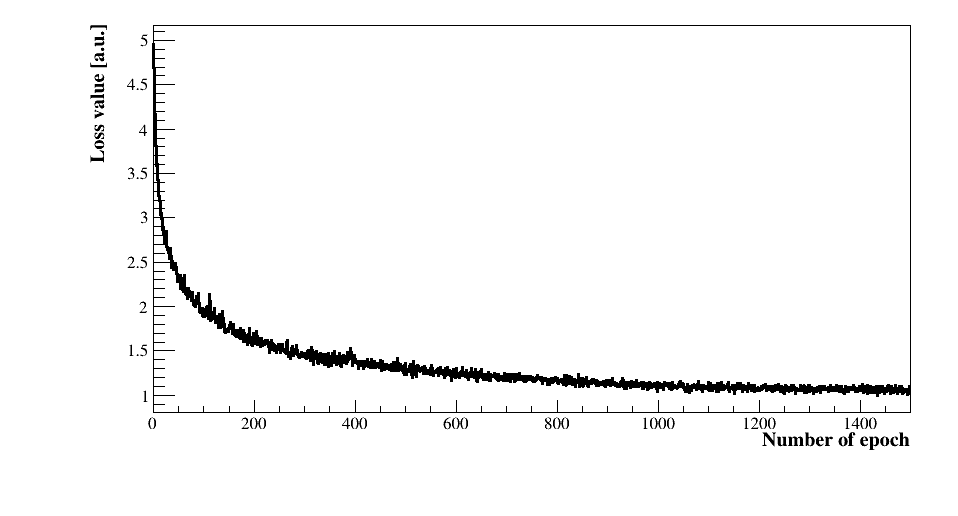

In [9]:
figs = [os.path.join(img_path, i) for i in os.listdir(img_path) if all(k in i for k in ["Loss", report.get_filename(), ".root"])] 
    
for ifig in figs:
    print(ifig)
    ifile = ROOT.TFile.Open( ifig )
    c = ifile.Get(report.get_filename())
    c.Draw()

**Cool! At this point you have trained your first model!**

#### Check for overtraining
A first sanity check of the trained model is performed by studying the evolution of its parameters as a function of the features. In such a way, inappropriate values of the learning rate, leading to an oscillating behaviour, or effects of overtraining, leading to abrupt variations of the parameters, can be excluded. 

The check can be implemented with: 

In [10]:
parameters  = {
     "trainDir"   : sorted([os.path.join("MODELS/", f) for f in os.listdir("MODELS")],
                            key =lambda x: os.path.getmtime(x))[-1], #(str)  directory where to load the training model from                   
     "nBins"      : 10                    ,  #(int)  number of features bins                                           
     "nSamples"   : 50000                 ,  #(int)  number of uniformly generated entries for validation              
     "nGaussians" : 8                     ,  #(int)  number of Gaussian in the model                                   
     "G_pars"     : ["width"]              }  #(list string) Gaussian parameters to scan (dflt [mean,width,weights] )   

vars_to_validate = [ "pi_P" ] #which variables do you want to consider? (dflt is all features)     

from pid4smog import Overtraining
overtraining = Overtraining( dataset, parameters)
overtraining.pars_evolution( report ) #go with the check for overtraining                                             

MODELS/PID_saved_model_report_tutorial_2021-01-03-11-50
INFO:tensorflow:Restoring parameters from MODELS/PID_saved_model_report_tutorial_2021-01-03-11-50/variables/variables
Studying now parameter evolutions with pi_P
Studying now parameter evolutions with pi_ETA
Studying now parameter evolutions with pi_TRACK_CHI2NDOF
Studying now parameter evolutions with nTracks


As an example, the evolution of the Gaussian width for the two target variables is shown here as a function of the pion momentum. Different line colours stand for the different Gaussian components. 

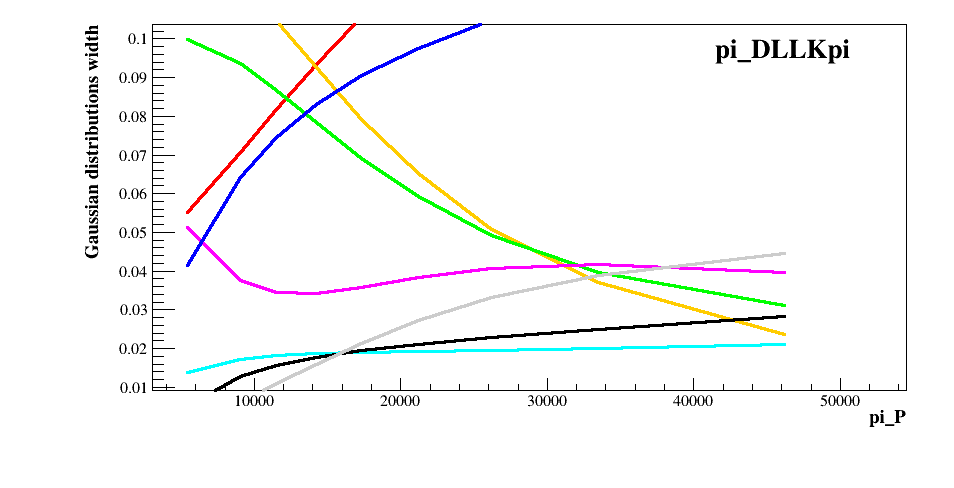

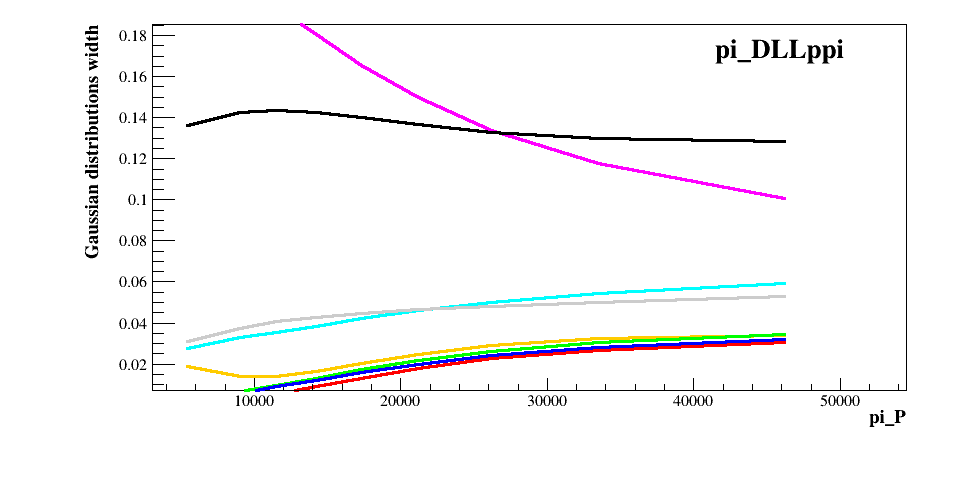

In [11]:
G_par = ["width"]
feature = ["pi_P"]

for ipar in G_par:
    for ifeat in feature:
        figs = [os.path.join(img_path, i) for i in os.listdir(img_path) if all(j in i for j in [ipar, report.get_filename(), ifeat, '.root'])]
        for ifig in figs:
            ifile = ROOT.TFile.Open(ifig)
            ic = ifile.Get(report.get_filename())
            ic.SetName("c_" + ifig)
            ic.Draw()
            
ROOT.gPad.SetName(report.get_filename())            

**Cool! a smooth behaviour is a good indication that the training went fine!**

#### Validation
We now have a trained model, i.e. the machine learning application has learned how the pion target variables depend on the set of considered features. To validate this, each feature is divided in bins with similar population and each possible feature pair is considered. For each bin of each feature pair, a comparison between the normalized training target and the model prediction is performed. By iterating throughput the whole multidimensional phase space, the learning of all the dependences and of their correlation can be validated.  

For each data-prediction comparison, the value of the Kolmogorov-Smirnov distance is evaluated

To launch the validation (This will also take a bit of time...):

In [12]:
parameters  = {
    "trainDir"   : sorted([os.path.join("MODELS/", f) for f in os.listdir("MODELS")],
                          key =lambda x: os.path.getmtime(x))[-1],  #(str)  directory where to load the training      
    "nBins"      : 2                     ,  #(int)  number of features bins                                           
    "nSamples"   : 5000000               ,  #(int)  number of uniformly generated entries for validation              
    "nProj"      : 2                     }  #(int)  number of bins to perform 2d histogram projection                 

vars_to_validate = { "pi_P" : None, "nTracks" : None }
#which variables and with which bins do you want to consider? (dflt binning is obtained with similar population)      
#weights = None #"sWeights?"                                                                                            

weights = weight                                                                                            

from pid4smog import Validation
validation = Validation( dataset, parameters, flags, weights = weights)
bins = validation.init_bins( report, vars_to_validate) #calculates binning scheme                                     
validation.do_validation( report, bins ) #performs validation

Validation bins :  pi_P :  OrderedDict([('nTracks', [10.0, 186.0, 994.0]), ('pi_P', [3057.638671875, 19063.3203125, 1263239.5])])
********************************************************************************
********************************************************************************
****************************** Starting VALIDATION******************************
********************************************************************************
********************************************************************************
INFO:tensorflow:Restoring parameters from MODELS/PID_saved_model_report_tutorial_2021-01-03-11-50/variables/variables
CONSIDERING NOW  nTracks  and  pi_P


As an example, a full validation in a pion momentum - number of tracks bin is shown. This comprehends the bidimensional target comarison, the projections onto the full two axes or considering intervals of one variable, so that both the monodimensional distribution and correlations can be checked. 

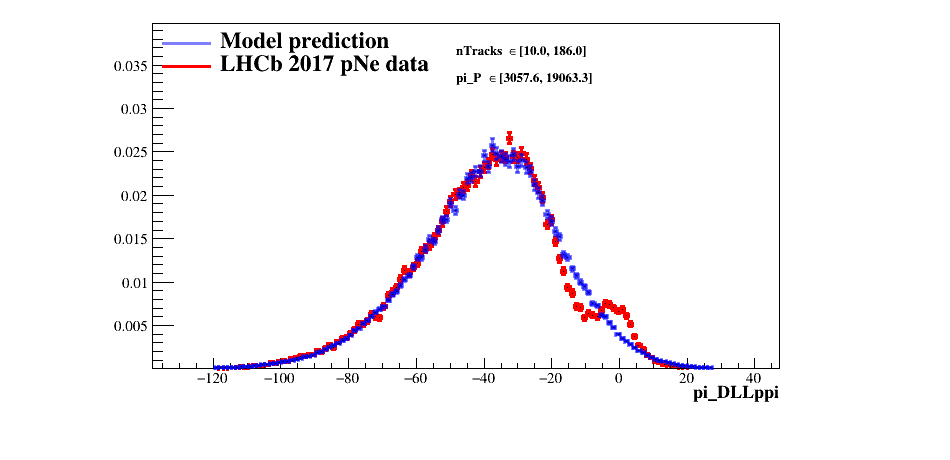

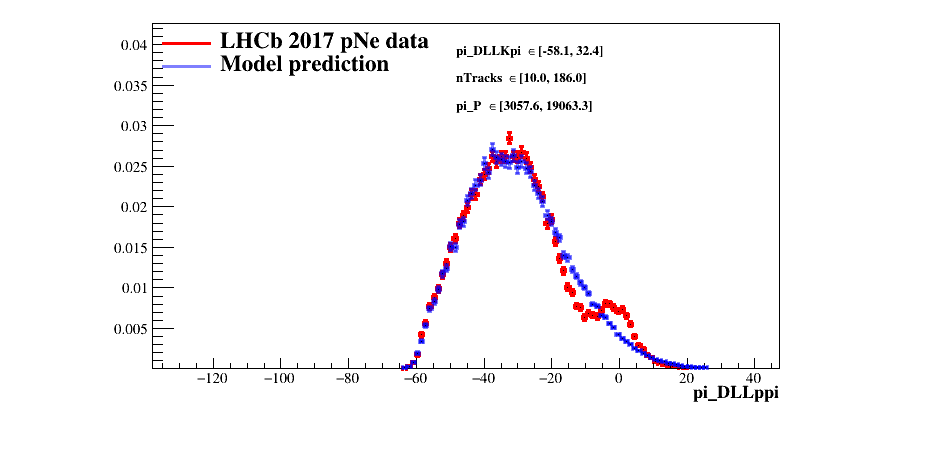

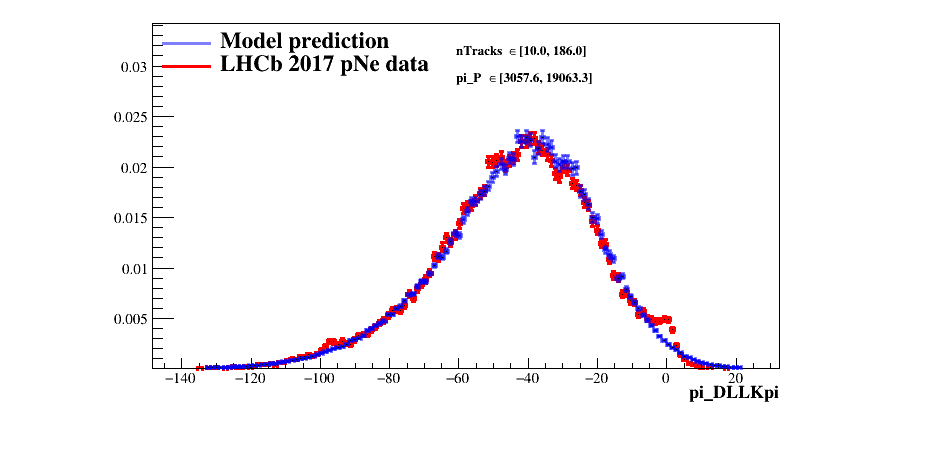

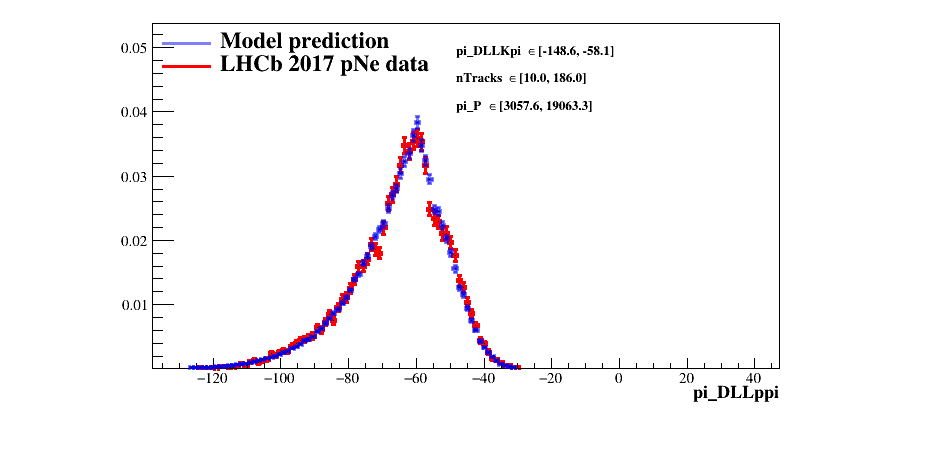

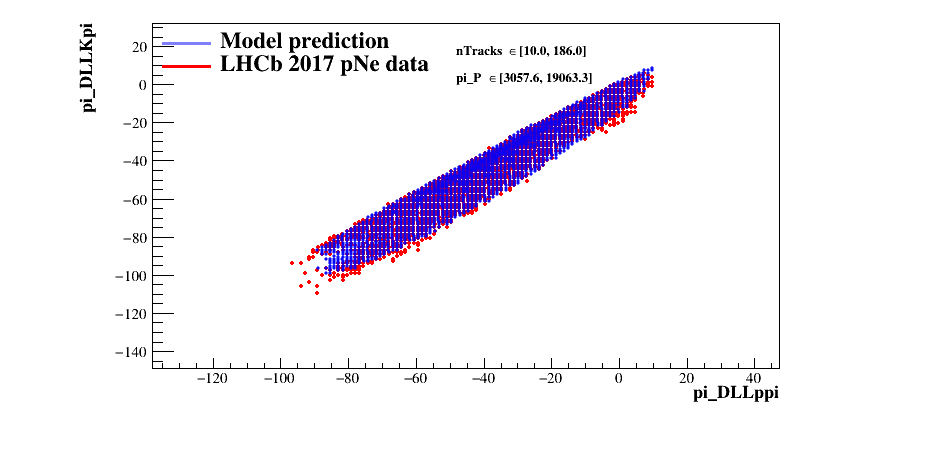

In [13]:
valid_bin = [ ["nTracks", "pi_P", 0, 0 ]] #Validation ID: features and bin index

all_figs = os.listdir(img_path)
for ibin in valid_bin:
    #print(os.listdir(img_path))
    figs = [ os.path.join(img_path, i ) for i in all_figs 
            if all(j in i for j in ibin[:2] + ["{:2.1f}".format( bins[ibin[0]][ibin[2]]).replace(".", "_") , 
                                               "{:2.1f}".format( bins[ibin[1]][ibin[3]]).replace(".", "_") ,
                                               "Valid", ".root"])]

    for ifig in figs:
        ifile = ROOT.TFile.Open(ifig)
        icanvas = ifile.Get(report.get_filename())
        icanvas.SetName("C_" + ifig)
        icanvas.Draw()
        

Well, it's a good performance, considering a few minutes training time and no optimization at all of the training parameters! How does the result change by increasing the number of Gaussians or the other parameters? Does it work when considering the proton DLL variables instead of the pion? How does it work when considering both signal and background events and including the weights for the signal hypothesis in the training?

Dependending on the physics use-case, what is learned by the model can be applied to a different sample than the training one. As an example, you can read [LINK_TO_PAPER]() how a set of models trained on $K_s \to \pi \pi$, $\bar{\Lambda} \to \bar{p}\pi$ and $\phi \to K K$ calibration channels collected in pNe collision with the LHCb fixed-target configuration are composed and fitted to the pHe and pAr ones, obtaining better or similar performance than a full-simulation approach

### Conclusions 

Based on the PID4SMOG package, this tutorial presented a minimal working example throughout the preprocessing, training, overtraining and validation phases applied on a random dataset mimicking $\Lambda_c \to p K \pi$ decays in LHCb *pp* data. A model with the composition of multinormal distributions whose parameters are initialized as a function of some relevant features through a set of Neural Netowrks is fitted to a training dataset. Iteratively, the target dependence on the set of fetaures is learned by the Neural Networks.

The model convergence is checked to be regular by studying the multinormal parameters as a function of the features and the learned dependences are checked by comparing the prediction with the actual target distribution. 

The trained model can be then composed and used for analysis purposes, depending on the physics use-case. 

Hope everything was clear, if not feel free to contact [me](mailto:mariani@fi.infn.it) or to open an issue [here](https://gitlab.cern.ch/samarian/pid4smog_module-/issues)